In [1]:
import json
import pandas as pd
from typing import Dict, List, Optional, Union
from pydantic import BaseModel, Field
from datasets import Dataset
from bespokelabs import curator
import argparse
from pathlib import Path
from typing import List, Dict

import os
os.environ["CURATOR_VIEWER"] = "1"
os.environ["BESPOKE_API_KEY"] = "bespoke-9ff97e97445794907bec5ef8d57fd925da61e8ba7586c17ec2dca4bdffb87b9b"

/Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============================================================================
# Pydantic Models for Structured Outputs
# ============================================================================

class MolecularProperty(BaseModel):
    """Molecular property prediction with confidence and reasoning."""
    property_name: str = Field(description="Name of the molecular property")
    predicted_value: float = Field(description="Predicted numerical value")
    confidence: str = Field(description="Confidence level: high, medium, low")
    reasoning: str = Field(description="Chemical reasoning for the prediction")
    key_structural_features: List[str] = Field(description="Important structural features affecting the property")


In [3]:
# ============================================================================
# Core Dataset Generators
# ============================================================================
class PropertyPredictor(curator.LLM):
    """Generates property prediction tasks with reasoning."""
    
    response_format = MolecularProperty
    
    def prompt(self, input: Dict) -> str:
        smiles = input['canonical_smiles']
        property_type = input.get('standard_type', 'LogD')

        return f"""You are an expert medicinal chemistry research assistant. You have knowledge in areas including:

- Drug design and development - structure-activity relationships (SAR), lead optimization, pharmacophore modeling
- Synthetic chemistry - reaction mechanisms, synthetic routes, protecting group strategies
- Pharmacology - drug-target interactions, pharmacokinetics (ADME), pharmacodynamics
- Computational chemistry - molecular modeling, QSAR and ADME predictions
- Analytical techniques - NMR, MS, HPLC and other characterization methods
- Medicinal chemistry strategies - bioisosteres, prodrugs, fragment-based drug design

Analyze the following molecule and predict its {property_type}.

Molecule (SMILES): {smiles}

Provide a detailed prediction including:
1. The predicted {property_type} value
2. Your confidence level
3. Chemical reasoning based on structural features
4. Key structural features that influence this property

Consider factors like:
- Lipophilicity and hydrophilicity
- Molecular weight and size
- Functional groups present
- Aromatic systems
- Hydrogen bonding potential
- Charge distribution"""

    def parse(self, input: Dict, response: MolecularProperty) -> Dict:
        return {
            "smiles": input['canonical_smiles'],
            "actual_value": input.get('standard_value'),
            "predicted_value": response.predicted_value,
            "property_type": input.get('standard_type', 'LogD'),
            "confidence": response.confidence,
            "reasoning": response.reasoning,
            "key_features": response.key_structural_features,
        }

In [4]:
df = pd.read_csv('/Users/ldodda/Documents/Codes/GraphGen/test_logd.csv')

## Sampling from all bins of LogD Data to make sure I am getting a diverse set

In [5]:
# Create bins for logd values covering the full range -8 to +8
import numpy as np

# Create 16 bins from -8 to +8
bins = np.linspace(-8, 8, 17)  # 17 edges create 16 bins
df['logd_bin'] = pd.cut(df['logd'], bins=bins, include_lowest=True)

# Sample from each bin (e.g., 20 samples per bin)
samples_per_bin = 100
sampled_df = df.groupby('logd_bin', observed=False, group_keys=False).apply(
    lambda x: x.sample(min(len(x), samples_per_bin), random_state=42)
)

print(f"Original dataset size: {len(df)}")
print(f"Sampled dataset size: {len(sampled_df)}")
print("\nSamples per bin:")
print(sampled_df['logd_bin'].value_counts().sort_index())
print(f"\nBin width: {(8 - (-8))/16} = 1.0 LogD unit per bin")

Original dataset size: 9999
Sampled dataset size: 1075

Samples per bin:
logd_bin
(-8.001, -7.0]      2
(-7.0, -6.0]        4
(-6.0, -5.0]        4
(-5.0, -4.0]       12
(-4.0, -3.0]       38
(-3.0, -2.0]       68
(-2.0, -1.0]      100
(-1.0, 0.0]       100
(0.0, 1.0]        100
(1.0, 2.0]        100
(2.0, 3.0]        100
(3.0, 4.0]        100
(4.0, 5.0]        100
(5.0, 6.0]        100
(6.0, 7.0]        100
(7.0, 8.0]         47
Name: count, dtype: int64

Bin width: 1.0 = 1.0 LogD unit per bin


/var/folders/2d/s6tm3wj949lf8cdhpv06q97r0000gr/T/ipykernel_18823/2257146822.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('logd_bin', observed=False, group_keys=False).apply(


In [6]:
sampled_df.drop(columns=['logd_bin'], inplace=True)

In [7]:
sampled_df

,smiles,logd
5046,CC(C)CCOc1ccc[n+](CC(P(=O)([O-])O)P(=O)(O)O)c1,-7.810
2726,NC(Cc1ccc(O)cc1)C(=O)O,-7.260
1794,CC(C)CCCC(C)CCn1cc[n+](CC(P(=O)([O-])O)P(=O)(O...,-6.070
2746,CN(C)C(N)=NC(=N)N,-6.130
453,O=P(O)(O)C(CNc1nccs1)P(=O)(O)O,-6.350
...,...,...
993,N#Cc1nc(-c2ccccc2)oc1S(=O)(=O)c1ccc(Cl)cc1,7.120
7280,COc1ccc(CNc2nc(NCCOC(=O)CCCCCCCCc3cn(CCC(=O)N[...,7.612
1702,CC(C)Oc1ccc(-c2nnc(-c3ccnn3C)s2)cc1Cl,7.040
4508,COC(=O)c1cc(OC(=O)c2ccc(OC)c(O)c2)c(OC)cc1CCN1...,7.280


In [8]:
sampled_df.columns = ['canonical_smiles', 'standard_value']
sampled_df['standard_type'] = 'LogD'

In [9]:
mol_data_dict = sampled_df.to_dict(orient='records')

In [10]:
logd_dataset = Dataset.from_list(mol_data_dict)

In [11]:
logd_dataset

Dataset({
    features: ['canonical_smiles', 'standard_value', 'standard_type'],
    num_rows: 1075
})

In [12]:
predictor = PropertyPredictor(
        model_name="bedrock/us.anthropic.claude-3-7-sonnet-20250219-v1:0",
        backend="litellm"
)

[11/02/25 23:56:12] INFO     Getting rate limits for model:                 ]8;id=153759;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/litellm_online_request_processor.py\litellm_online_request_processor.py]8;;\:]8;id=936898;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/litellm_online_request_processor.py#213\213]8;;\
                             bedrock/us.anthropic.claude-3-7-sonnet-2025021                                        
                             9-v1:0                                                                                

[11/02/25 23:56:15] INFO     Test call headers: {}                          ]8;id=925512;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/litellm_online_request_processor.py\litellm_online_request_processor.py]8;;\:]8;id=454837;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/litellm_online_request_processor.py#199\199]8;;\

In [13]:
print("Generating predictions...")
results = predictor(logd_dataset)


Generating predictions...


                    INFO     Authenticated with Curator API key                                        ]8;id=491703;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/client.py\client.py]8;;\:]8;id=247296;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/client.py#42\42]8;;\

                    INFO     Running LiteLLMOnlineRequestProcessor completions with   ]8;id=309075;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=43779;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#133\133]8;;\
                             model:                                                                                
                             bedrock/us.anthropic.claude-3-7-sonnet-20250219-v1:0                                  

                    INFO     Preparing request file(s) in                             ]8;id=799733;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=894975;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#233\233]8;;\
                             /Users/ldodda/.cache/curator/4399f71845da8900                                         

                    INFO     Wrote 1075 requests to                                   ]8;id=671793;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=635371;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#315\315]8;;\
                             /Users/ldodda/.cache/curator/4399f71845da8900/requests_0                              
                             .jsonl.                                                                               

                    WARNING  No manual max_requests_per_minute set, and        ]8;id=564748;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=786131;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#197\197]8;;\
                             headers based detection failed, using default                                         
                             value of 200                                                                          

                    WARNING  No manual max_tokens_per_minute set, and headers  ]8;id=875940;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=394486;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#216\216]8;;\
                             based detection failed, using default value of                                        
                             100000                                                                                

/Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • Time Elapsed 0:14:06 • Time Remaining 0:00:00

Curator Viewer: ]8;id=985130;https://curator.bespokelabs.ai/datasets/cdd963217761402bb22b071193622ff6\✨ Open Curator Viewer]8;;\ ✨                                                                         
https://curator.bespokelabs.ai/datasets/cdd963217761402bb22b071193622ff6                                          
Requests: Total: 1075 • Cached: 0✓ • Success: 1075✓ • Failed: 0✗ • In Progress: 0⋯ • Req/min: 76.2 • Res/min: 76.2
Tokens: Avg Input: 849 • Input TPM: 64631 • Avg Output: 458 • Output TPM: 34850                                   
Cost: Current: $0.000 • Est. Total: $0.000 ($0.000 remaining) • Rate: $0.000/min                                  
Rate Limits: RPM: 200 • TPM: 100000 • TPM Strategy: combined token limit                                          
Model: Name: bedrock/us.anthropic.claude-3-7-sonnet-20250219-v1:0                                                 
Model Pricing: Per 1M tokens: Input: N/A • Output: N/A

                              Final Curator Statistics                               
╭────────────────────────────┬──────────────────────────────────────────────────────╮
│ Section/Metric             │ Value                                                │
├────────────────────────────┼──────────────────────────────────────────────────────┤
│ Model                      │                                                      │
│ Name                       │ bedrock/us.anthropic.claude-3-7-sonnet-20250219-v1:0 │
│ Rate Limit (RPM)           │ 200                                                  │
│ Rate Limit (TPM)           │ 100000                                               │
│ Requests                   │                                                      │
│ Total Processed            │ 1075                                                 │
│ Successful                 │ 1075                                                 │
│ Failed                     │ 0                                                    │
│ Tokens                     │                                                      │
│ Total Tokens Used          │ 1,404,261                                            │
│ Total Input Tokens         │ 912,325                                              │
│ Total Output Tokens        │ 491,936                                              │
│ Average Tokens per Request │ 1306                                                 │
│ Average Input Tokens       │ 848                                                  │
│ Average Output Tokens      │ 457                                                  │
│ Costs                      │                                                      │
│ Total Cost                 │ $0.000                                               │
│ Average Cost per Request   │ $0.000                                               │
│ Input Cost per 1M Tokens   │ N/A                                                  │
│ Output Cost per 1M Tokens  │ N/A                                                  │
│ Performance                │                                                      │
│ Total Time                 │ 846.97s                                              │
│ Average Time per Request   │ 0.79s                                                │
│ Requests per Minute        │ 76.2                                                 │
│ Responses per Minute       │ 76.2                                                 │
│ Max Concurrent Requests    │ 33                                                   │
│ Input Tokens per Minute    │ 64629.6                                              │
│ Output Tokens per Minute   │ 34849.0                                              │
╰────────────────────────────┴──────────────────────────────────────────────────────╯

[11/03/25 00:10:22] INFO     Processing complete. Results saved to             ]8;id=795441;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=511654;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#459\459]8;;\
                             /Users/ldodda/.cache/curator/4399f71845da8900/res                                     
                             ponses_0.jsonl                                                                        

                    INFO     Status tracker: Tasks - Started: 1075, In         ]8;id=688938;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=953807;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#460\460]8;;\
                             Progress: 0, Succeeded: 1075, Failed: 0, Already                                      
                             Completed: 0                                                                          
                             Errors - API: 0, Rate Limit: 0, Other: 0, Total:                                      
                             0                                                                                     

                    INFO     Read 1075 responses.                                     ]8;id=225312;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=981611;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#444\444]8;;\

                    INFO     Finalizing writer                                        ]8;id=245576;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=745645;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#453\453]8;;\

                    INFO     Creating a file with all failed requests                 ]8;id=642533;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=202709;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#462\462]8;;\

                    INFO     Created file with failed requests at                     ]8;id=204948;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=91606;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#490\490]8;;\
                             /Users/ldodda/.cache/curator/4399f71845da8900/failed_req                              
                             uests.jsonl                                                                           

In [14]:
print("\n📊 Results:")
logD_dataset_df = results.dataset.to_pandas()


📊 Results:


In [15]:
logD_dataset_df

,smiles,actual_value,predicted_value,property_type,confidence,reasoning,key_features
0,CC(C)CCOc1ccc[n+](CC(P(=O)([O-])O)P(=O)(O)O)c1,-7.810,-3.2,LogD,high,This molecule contains features that strongly ...,"[Positively charged pyridinium moiety, Two pho..."
1,NC(Cc1ccc(O)cc1)C(=O)O,-7.260,-1.7,LogD,high,"The molecule is tyrosine, an amino acid with s...","[Carboxylic acid group, Phenol group, Primary ..."
2,CC(C)CCCC(C)CCn1cc[n+](CC(P(=O)([O-])O)P(=O)(O...,-6.070,-2.8,LogD,medium,The molecule contains a charged imidazolium ca...,"[Imidazolium cation, Bisphosphonate group, Alk..."
3,CN(C)C(N)=NC(=N)N,-6.130,-2.4,LogD,high,"The molecule CN(C)C(N)=NC(=N)N is metformin, a...","[Multiple guanidine groups, Tertiary amine (di..."
4,O=P(O)(O)C(CNc1nccs1)P(=O)(O)O,-6.350,-3.5,LogD,high,The molecule is a bisphosphonate derivative co...,"[Two phosphonic acid groups, Thiazole ring, Se..."
...,...,...,...,...,...,...,...
1070,N#Cc1nc(-c2ccccc2)oc1S(=O)(=O)c1ccc(Cl)cc1,7.120,2.8,LogD,medium,The molecule contains both lipophilic and hydr...,"[Chlorophenyl moiety (lipophilic), Sulfone gro..."
1071,COc1ccc(CNc2nc(NCCOC(=O)CCCCCCCCc3cn(CCC(=O)N[...,7.612,4.8,LogD,medium,"The molecule is a large, complex structure wit...","[Long alkyl chain (C8), Multiple methoxy group..."
1072,CC(C)Oc1ccc(-c2nnc(-c3ccnn3C)s2)cc1Cl,7.040,3.5,LogD,medium,The molecule CC(C)Oc1ccc(-c2nnc(-c3ccnn3C)s2)c...,"[Chlorinated aromatic ring, Isopropoxy group, ..."
1073,COC(=O)c1cc(OC(=O)c2ccc(OC)c(O)c2)c(OC)cc1CCN1...,7.280,2.4,LogD,medium,The molecule contains a mix of lipophilic and ...,"[Methoxy groups (hydrophobic), Ester groups (m..."


In [16]:
results.dataset

Dataset({
    features: ['smiles', 'actual_value', 'predicted_value', 'property_type', 'confidence', 'reasoning', 'key_features'],
    num_rows: 1075
})

In [17]:
results.dataset.to_list()

[{'smiles': 'CC(C)CCOc1ccc[n+](CC(P(=O)([O-])O)P(=O)(O)O)c1',
  'actual_value': -7.81,
  'predicted_value': -3.2,
  'property_type': 'LogD',
  'confidence': 'high',
  'reasoning': 'This molecule contains features that strongly influence its LogD value. The presence of a positively charged pyridinium nitrogen creates a permanent positive charge, significantly reducing lipophilicity. The molecule also contains two phosphonate groups (P(=O)(O)O and P(=O)([O-])O), which are highly polar and include a negatively charged oxygen, contributing substantial hydrophilicity. These charged and polar groups will dominate the partitioning behavior, driving the molecule toward the aqueous phase despite the presence of the moderately lipophilic isobutoxy group (CC(C)CCO-). The phosphonate groups also provide multiple hydrogen bond acceptors and donors, further enhancing water solubility. The molecular weight (approximately 380-400 Da) is moderate but the highly charged and polar nature of the functiona

In [18]:
output_file = "logd_predictor.jsonl"
with open(output_file, 'w') as f:
    for item in results.dataset.to_list():
        f.write(json.dumps(item) + '\n')

In [19]:
"""
Data Preparation Script for Llama 3.2 3B Fine-tuning
Converts bespokelabs-curator dataset to instruction-following format
"""

system_prompt = """You are an expert medicinal chemistry research assistant. You have knowledge in areas including:

- Drug design and development - structure-activity relationships (SAR), lead optimization, pharmacophore modeling
- Synthetic chemistry - reaction mechanisms, synthetic routes, protecting group strategies
- Pharmacology - drug-target interactions, pharmacokinetics (ADME), pharmacodynamics
- Computational chemistry - molecular modeling, QSAR and predicting ADME properties
- Analytical techniques - NMR, MS, HPLC and other characterization methods
- Medicinal chemistry strategies - bioisosteres, prodrugs, fragment-based drug design

You analyze molecular structures using SMILES notation and provide accurate predictions for LogD values (distribution coefficient at pH 7.4). 
Your predictions are based on careful analysis of structural features, lipophilic and hydrophilic contributions, and established cheminformatics principles.
"""
class DatasetConverter:
    """Convert molecular property dataset to instruction-following format."""
    
    def __init__(self, input_path: str, output_path: str):
        self.input_path = Path(input_path)
        self.output_path = Path(output_path)
        
        if not self.input_path.exists():
            raise FileNotFoundError(f"Input file not found: {input_path}")
    
    def convert_to_instruction_format(self) -> None:
        """Convert dataset to Llama 3.2 instruction format."""
        
        print(f"Reading dataset from: {self.input_path}")
        
        with open(self.input_path, 'r') as f_in:
            with open(self.output_path, 'w') as f_out:
                example_count = 0
                
                for line_num, line in enumerate(f_in, 1):
                    try:
                        example = json.loads(line)
                        converted = self._create_instruction_example(example)
                        f_out.write(json.dumps(converted) + '\n')
                        example_count += 1
                        
                    except json.JSONDecodeError as e:
                        print(f"Warning: Invalid JSON on line {line_num}: {e}")
                    except KeyError as e:
                        print(f"Warning: Missing field on line {line_num}: {e}")
        
        print(f"✓ Converted {example_count} examples")
        print(f"✓ Output saved to: {self.output_path}")
    
    @staticmethod
    def _create_instruction_example(entry: Dict) -> Dict:
        """
        Convert single entry to instruction format.
        
        Args:
            entry: Original entry with SMILES, values, and reasoning
            
        Returns:
            Dictionary with 'text' field containing formatted conversation
        """
        
        smiles = entry['smiles']
        actual_value = entry['actual_value']
        reasoning = entry['reasoning']
        key_features = ', '.join(entry['key_features'])
        
        # Create the full conversation in Llama 3.2 format
        text = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
{system_prompt}
<|eot_id|><|start_header_id|>user<|end_header_id|>
Analyze the following molecule and predict its LogD value.

SMILES: {smiles}

Key Structural Features: {key_features}

Chemical Analysis and Reasoning:
{reasoning}

Based on this analysis, what is the predicted LogD value for this molecule?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
Based on the detailed structural analysis, considering the balance of lipophilic and hydrophilic features:

The predicted LogD value is: **{actual_value}**

This prediction reflects:
- The lipophilic contributions from the {key_features.split(',')[0] if ',' in key_features else 'aromatic and aliphatic components'}
- The hydrophilic contributions from polar functional groups
<|eot_id|>"""
        
        return {"text": text}
    
    def validate_output(self) -> bool:
        """Validate the converted dataset."""
        
        print("\nValidating dataset...")
        
        try:
            examples = []
            with open(self.output_path, 'r') as f:
                for i, line in enumerate(f):
                    ex = json.loads(line)
                    if 'text' not in ex:
                        raise ValueError(f"Line {i}: missing 'text' field")
                    examples.append(ex)
            
            print(f"✓ Valid JSONL format")
            print(f"✓ Number of examples: {len(examples)}")
            
            # Show statistics
            text_lengths = [len(ex['text']) for ex in examples]
            print(f"✓ Average text length: {sum(text_lengths) / len(text_lengths):.0f} chars")
            print(f"✓ Min length: {min(text_lengths)} chars")
            print(f"✓ Max length: {max(text_lengths)} chars")
            
            # Show sample
            print(f"\n--- Sample Example (first 500 chars) ---")
            print(examples[0]['text'][:500] + "...\n")
            
            return True
            
        except Exception as e:
            print(f"✗ Validation failed: {e}")
            return False

In [20]:
converter = DatasetConverter('./logd_predictor.jsonl', './logd_formatted.jsonl')
converter.convert_to_instruction_format()

Reading dataset from: logd_predictor.jsonl
✓ Converted 1075 examples
✓ Output saved to: logd_formatted.jsonl


In [22]:
from datasets import Dataset


def load_jsonl_data(file_path):
    """Load JSONL dataset."""
    texts = []
    with open(file_path, 'r') as f:
        for line in f:
            example = json.loads(line)
            texts.append(example['text'])
    return texts

DATASET_PATH = './logd_formatted.jsonl'
print(f"Loading dataset from {DATASET_PATH}...")
texts = load_jsonl_data(DATASET_PATH)
print(f"Loaded {len(texts)} examples")

# Create HF dataset
dataset = Dataset.from_dict({
    'text': texts
})

Loading dataset from ./logd_formatted.jsonl...
Loaded 1075 examples


In [23]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [24]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 860
    })
    test: Dataset({
        features: ['text'],
        num_rows: 215
    })
})

📊 LogD Prediction Performance Metrics:
Mean Squared Error (MSE):     5.1906
Root Mean Squared Error (RMSE): 2.2783
Mean Absolute Error (MAE):    1.8387
R² Score:                     0.4939
Pearson Correlation:          0.7275
Spearman Correlation:         0.7582
Spearman p-value:             1.73e-201


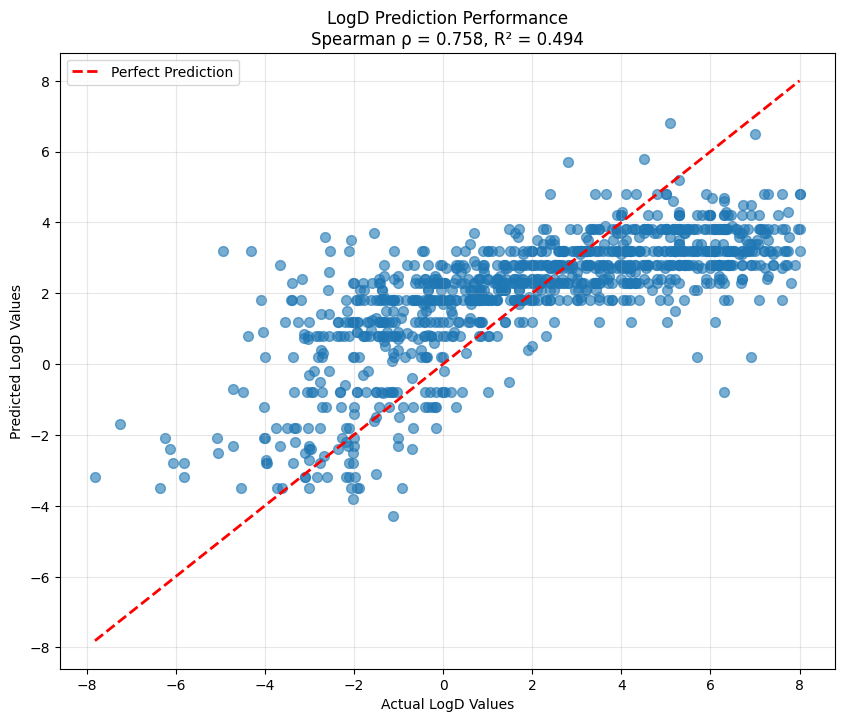

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

import matplotlib.pyplot as plt

# Calculate regression metrics
actual_values = logD_dataset_df['actual_value']
predicted_values = logD_dataset_df['predicted_value']

# Regression metrics
mse = mean_squared_error(actual_values, predicted_values)
rmse = mse ** 0.5
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

# Spearman correlation
spearman_corr, spearman_p = spearmanr(actual_values, predicted_values)

# Pearson correlation (for comparison)
pearson_corr = actual_values.corr(predicted_values)

print("📊 LogD Prediction Performance Metrics:")
print("=" * 50)
print(f"Mean Squared Error (MSE):     {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):    {mae:.4f}")
print(f"R² Score:                     {r2:.4f}")
print(f"Pearson Correlation:          {pearson_corr:.4f}")
print(f"Spearman Correlation:         {spearman_corr:.4f}")
print(f"Spearman p-value:             {spearman_p:.2e}")

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(actual_values, predicted_values, alpha=0.6, s=50)
plt.plot([actual_values.min(), actual_values.max()], 
         [actual_values.min(), actual_values.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual LogD Values')
plt.ylabel('Predicted LogD Values')
plt.title(f'LogD Prediction Performance\nSpearman ρ = {spearman_corr:.3f}, R² = {r2:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

📊 LogD Zone Classification Performance:
Overall Accuracy: 0.6298

Classification Report:
                  precision    recall  f1-score   support

       High (>4)       0.86      0.13      0.22       347
       Low (<-2)       0.80      0.36      0.50       121
Medium (-2 to 4)       0.61      0.97      0.75       607

        accuracy                           0.63      1075
       macro avg       0.76      0.49      0.49      1075
    weighted avg       0.71      0.63      0.55      1075



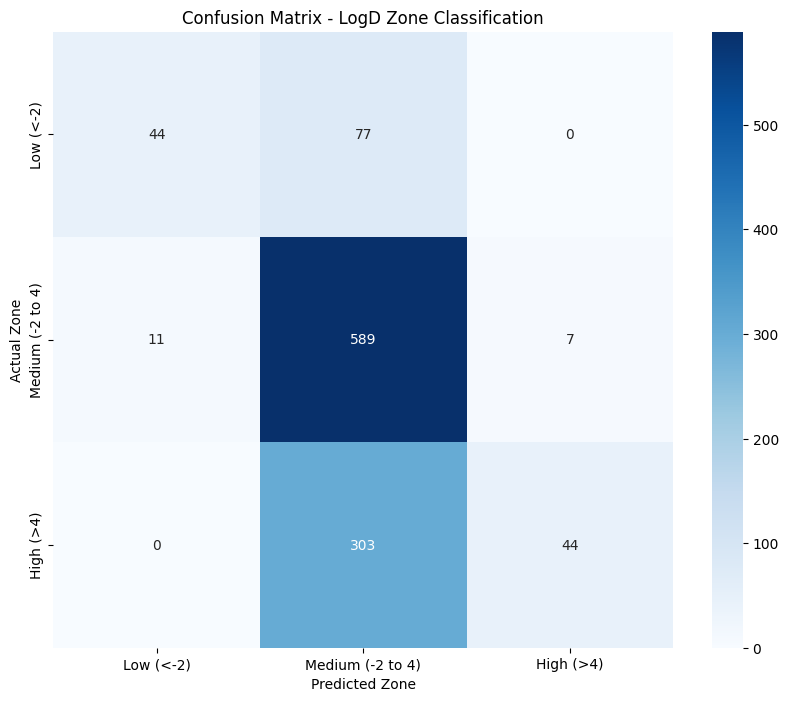


📈 Zone Distribution:
Actual zones:
actual_zone
High (>4)           347
Low (<-2)           121
Medium (-2 to 4)    607
Name: count, dtype: int64

Predicted zones:
predicted_zone
High (>4)            51
Low (<-2)            55
Medium (-2 to 4)    969
Name: count, dtype: int64


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Create LogD zones classification
def classify_logd(value):
    if value < -2:
        return 'Low (<-2)'
    elif value <= 4:
        return 'Medium (-2 to 4)'
    else:
        return 'High (>4)'

# Apply classification to actual and predicted values
logD_dataset_df['actual_zone'] = actual_values.apply(classify_logd)
logD_dataset_df['predicted_zone'] = predicted_values.apply(classify_logd)

# Generate classification statistics

# Calculate classification metrics
accuracy = accuracy_score(logD_dataset_df['actual_zone'], logD_dataset_df['predicted_zone'])

print("📊 LogD Zone Classification Performance:")
print("=" * 60)
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(logD_dataset_df['actual_zone'], logD_dataset_df['predicted_zone']))

# Create confusion matrix
cm = confusion_matrix(logD_dataset_df['actual_zone'], logD_dataset_df['predicted_zone'], 
                     labels=['Low (<-2)', 'Medium (-2 to 4)', 'High (>4)'])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low (<-2)', 'Medium (-2 to 4)', 'High (>4)'],
            yticklabels=['Low (<-2)', 'Medium (-2 to 4)', 'High (>4)'])
plt.title('Confusion Matrix - LogD Zone Classification')
plt.xlabel('Predicted Zone')
plt.ylabel('Actual Zone')
plt.show()

# Show distribution of zones
print("\n📈 Zone Distribution:")
print("Actual zones:")
print(logD_dataset_df['actual_zone'].value_counts().sort_index())
print("\nPredicted zones:")
print(logD_dataset_df['predicted_zone'].value_counts().sort_index())

In [32]:
dataset.push_to_hub("lsdodda/LogD-Predictor")

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 55.68ba/s]
Processing Files (1 / 1): 100%|██████████|  682kB /  682kB,  569kB/s  
New Data Upload: 100%|██████████|  682kB /  682kB,  569kB/s  
Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 277.55ba/s]
Processing Files (1 / 1): 100%|██████████|  180kB /  180kB,  450kB/s  
New Data Upload: 100%|██████████|  180kB /  180kB,  450kB/s  
Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/lsdodda/LogD-Predictor/commit/0fed77ac082743e72f658174e9b60249a3afe52c', commit_message='Upload dataset', commit_description='', oid='0fed77ac082743e72f658174e9b60249a3afe52c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/lsdodda/LogD-Predictor', endpoint='https://huggingface.co', repo_type='dataset', repo_id='lsdodda/LogD-Predictor'), pr_revision=None, pr_num=None)